In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from Bio.SeqIO.FastaIO import SimpleFastaParser
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier


In [2]:
input_hot = 'hot_regions_01_all.fa'
input_lot = 'lot_regions_01_all.fa'
kmer_length = 4
sampling_percentage = 1
seed = 35

In [3]:
with open(input_hot) as fasta_file:
    hot_sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        hot_sequences.append(sequence)

with open(input_lot) as fasta_file:
    lot_sequences = []
    for title, sequence in SimpleFastaParser(fasta_file):
        lot_sequences.append(sequence)

In [4]:
hot_region_100bp = []
m = 1000

for seq in hot_sequences:
    bp100 = [ seq[i:i+m].upper() for i in range(0,len(seq)-m+1, m)]
    hot_region_100bp.extend(bp100)

lot_region_100bp = []

for seq in lot_sequences:
    bp100 = [ seq[i:i+m].upper() for i in range(0,len(seq)-m+1, m)]
    lot_region_100bp.extend(bp100)

In [5]:
print(len(lot_region_100bp))
print(len(hot_region_100bp))


650
632


In [20]:
#[len(x) for x in lot_region_100bp if len(x)!=200]

In [6]:
nucleotides = ['A', 'C', 'G', 'T', 'N' ]
    
def seq_to_onehot(seq, nucleotides = nucleotides, maxLen = 1000):
    import numpy as np
    char_to_int = dict((c, i) for i, c in enumerate(nucleotides))
    int_to_char = dict((i, c) for i, c in enumerate(nucleotides))

    seq_to_int = [ char_to_int[c] for c in seq] 

    n_row = maxLen
    n_col = len(nucleotides)

    onehot = np.zeros((n_row, n_col), dtype=int)

    for i, x in enumerate(seq_to_int):
        if i == maxLen:
            break
        onehot[i][x] = 1
    
    return onehot

In [7]:
import time 
hot_set = []
start = time.time()
for seq in hot_region_100bp:
    onehot = seq_to_onehot(seq)
    hot_set.append(onehot)
end = time.time()
print(end-start)

lot_set = []
start = time.time()
for seq in lot_region_100bp:
    onehot = seq_to_onehot(seq)
    lot_set.append(onehot)
end = time.time()
print(end-start)

0.2239539623260498
0.18543624877929688


In [8]:
hot_set = np.array(hot_set)
print(hot_set.shape)
lot_set = np.array(lot_set)
print(lot_set.shape)

(632, 1000, 5)
(650, 1000, 5)


In [9]:
X = np.concatenate([hot_set, lot_set], axis=0)
X.shape

(1282, 1000, 5)

In [10]:
y = np.concatenate([np.ones(shape=(hot_set.shape[0],1)), np.zeros(shape=(lot_set.shape[0],1))], axis=0)
y.shape

(1282, 1)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 2,  stratify=y)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))



(array([0., 1.]), array([520, 505]))
(array([0., 1.]), array([130, 127]))


In [12]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

2022-11-11 20:26:40.741294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
inputs = keras.Input(shape= X_train.shape[1:], name="Input Sequence")

x_a = layers.Conv1D(filters = 256, kernel_size = 1, padding='same', activation='relu')(inputs)
x_b = layers.Conv1D(filters = 256, kernel_size = 3, padding='same', activation='relu')(inputs)
x_c = layers.Conv1D(filters = 256, kernel_size = 5, padding='same', activation='relu')(inputs)
x_d = layers.Conv1D(filters = 256, kernel_size = 9, padding='same', activation='relu')(inputs)
x_e = layers.Conv1D(filters = 256, kernel_size = 15, padding='same', activation='relu')(inputs)

#x_1 = layers.Concatenate(axis=1)([x_a, x_b, x_c, x_d, x_e])

x_1 = layers.Maximum()([x_a, x_b, x_c, x_d, x_e])

x_1_1 = layers.Conv1D(filters = 128, kernel_size = 5, padding='same', activation='relu')(x_1)
x_1_1 = layers.BatchNormalization()(x_1_1)


# x_1_c = layers.Conv1D(filters = 64, kernel_size = 5, activation='relu')(x_1)

# x_2a = layers.Conv1D(filters = 120, kernel_size = 1, padding='same', activation='relu')(inputs)
# x_2b = layers.Conv1D(filters = 120, kernel_size = 3, padding='same', activation='relu')(inputs)
# x_2c = layers.Conv1D(filters = 120, kernel_size = 5, padding='same', activation='relu')(inputs)
# x_2d = layers.Conv1D(filters = 120, kernel_size = 9, padding='same', activation='relu')(inputs)
# x_2e = layers.Conv1D(filters = 120, kernel_size = 15, padding='same', activation='relu')(inputs)

x_2 = layers.Add()([x_a, x_b, x_c, x_d, x_e])

x_2_c = layers.Conv1D(filters = 128, kernel_size = 5, padding='same', activation='relu')(x_2)
x_2_c = layers.BatchNormalization()(x_2_c)

x = layers.Concatenate(axis=1)([x_1_1, x_2_c])

x = layers.Flatten()(x)
#x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="hot_model")

2022-11-11 20:26:46.179907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.summary()

Model: "hot_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Sequence (InputLayer)    [(None, 1000, 5)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1000, 256)    1536        ['Input Sequence[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1000, 256)    4096        ['Input Sequence[0][0]']         
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1000, 256)    6656        ['Input Sequence[0][0]']         
                                                                                          

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.FalseNegatives()])

checkpoint = keras.callbacks.ModelCheckpoint(filepath='my_best_model.epoch{epoch:02d}-acc{val_binary_accuracy:.2f}.hdf5', 
                             monitor='val_binary_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

In [17]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    verbose='auto',
    callbacks=[checkpoint],
    validation_split=0.25,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True
)

Epoch 1/100
24/24 [==============================] - 17s 711ms/step - loss: 0.3899 - binary_accuracy: 0.8516 - false_positives: 101.0000 - false_negatives: 13.0000 - val_loss: 0.7468 - val_binary_accuracy: 0.5019 - val_false_positives: 127.0000 - val_false_negatives: 1.0000
Epoch 2/100
24/24 [==============================] - 26s 1s/step - loss: 0.3625 - binary_accuracy: 0.8763 - false_positives: 75.0000 - false_negatives: 20.0000 - val_loss: 0.7414 - val_binary_accuracy: 0.5331 - val_false_positives: 120.0000 - val_false_negatives: 0.0000e+00
Epoch 3/100
24/24 [==============================] - 25s 1s/step - loss: 0.3694 - binary_accuracy: 0.8698 - false_positives: 90.0000 - false_negatives: 10.0000 - val_loss: 0.7552 - val_binary_accuracy: 0.5370 - val_false_positives: 119.0000 - val_false_negatives: 0.0000e+00
Epoch 4/100
24/24 [==============================] - 15s 642ms/step - loss: 0.3428 - binary_accuracy: 0.8685 - false_positives: 92.0000 - false_negatives: 9.0000 - val_loss: 0

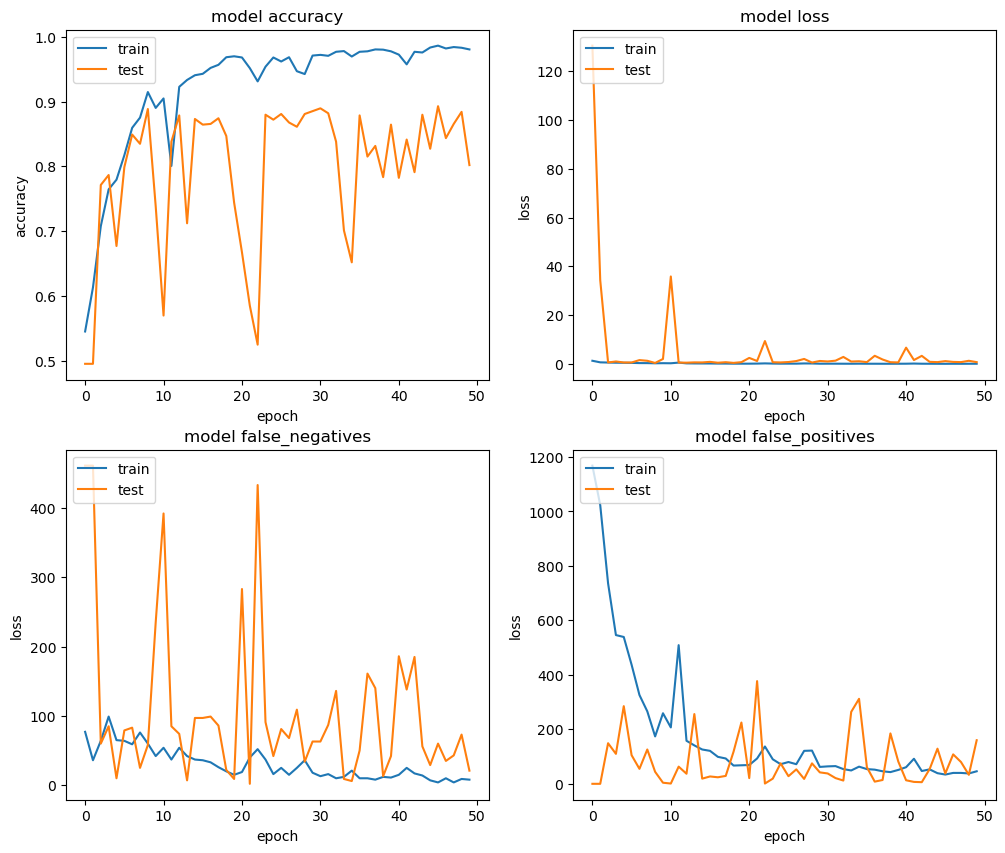

In [132]:
metrics = history.history.keys()
fig = plt.figure(figsize=(12,10))
# summarize history for accuracy
plt.subplot(2,2,1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for false_negatives
plt.subplot(2,2,3)
plt.plot(history.history['false_negatives_7'])
plt.plot(history.history['val_false_negatives_7'])
plt.title('model false_negatives')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()

# summarize history for false_positives
plt.subplot(2,2,4)
plt.plot(history.history['false_positives_2'])
plt.plot(history.history['val_false_positives_2'])
plt.title('model false_positives')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [96]:
y_pred = model.predict(X_test)

29/29 [==============================] - 2s 76ms/step


In [97]:
y_pred_hat = [1 if y>0.5 else 0 for y in y_pred]

              precision    recall  f1-score   support

           0       0.62      0.93      0.75       307
           1       0.95      0.71      0.82       607

    accuracy                           0.79       914
   macro avg       0.79      0.82      0.78       914
weighted avg       0.84      0.79      0.79       914



<AxesSubplot:>

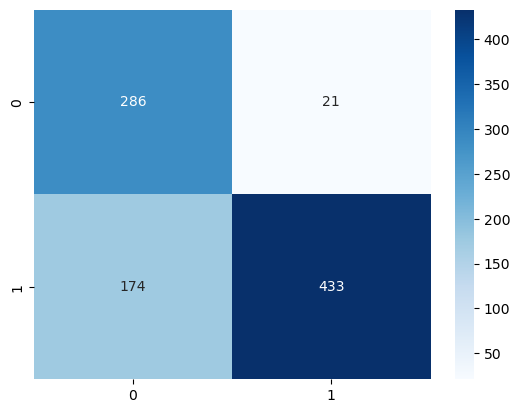

In [98]:
from sklearn.metrics import classification_report, confusion_matrix

cr = classification_report(y_pred_hat, y_test)
print(cr)

cm = confusion_matrix(y_pred_hat, y_test)
sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")

In [134]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [135]:
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk
